[![taxi.png](https://i.postimg.cc/kXw5dQW3/taxi.png)](https://postimg.cc/8jJGRryt)

<div style="padding:20px 20px 20px; 
            color:#004346;
            font-size:40px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;">Прогнозирование заказов такси</p>

</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    
__Заказчик:__ Компания «Чётенькое такси».
    
__Постановка задачи:__ Для привлечения водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час, построив модель.
    
__Оценка результата:__ Сравнение качества работы моделей. Значение метрики RMSE на тестовой выборке должно быть не больше 48.
    
__Описание данных:__ Исторические данные о заказах такси в аэропортах
    
</div>    

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Используемые библиотеки

</div>

In [1]:
! pip install statsmodels

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split

from sklearn.model_selection import TimeSeriesSplit, cross_val_predict
from sklearn.metrics import mean_squared_error
from math import sqrt
import optuna

from sklearn.linear_model import Ridge

import lightgbm as lgb

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

# константы
RANDOM_SEED = 42

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Загрузка данных

</div>

In [3]:
# загрузка данных:
try:
    df = pd.read_csv('datasets/taxi.csv')
    display(df.head(2))
except:
    display('Данные не доступны')

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:13px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Предобработка и исследовательский анализ данных

## Общая информация

</div>

In [4]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

__Проверим пропуски в данных:__

In [5]:
print(f'Общее количество пропусков в данных: {sum(col_pas for col_pas in df.isna().sum())}')

Общее количество пропусков в данных: 0


__Проверим дубликатов в данных:__

In [6]:
print(f'Общее количество дубликатов в данных: {df.duplicated().sum()}')

Общее количество дубликатов в данных: 0


<div style="padding: 30px 25px; border: 2px #6495ed solid">

- Данные загружены корректно.
- Пропуски в данных отсутствуют.
- Дублитакы в данных отсутствуют.
    
__Недостатки:__
- Признак `datetime` представлен в типе object, следует изменить на datetime64
    
</div>

__Обработка типов данных:__

In [7]:
df['datetime'] = pd.to_datetime(df['datetime'])

__Установка индекса таблицы равным столбцу `datetime` и отсортируем по возрастанию:__

In [8]:
df = df.set_index('datetime')
df = df.sort_index(ascending=True)
display(df.head(2))
display(df.info())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Анализ и обработка данных
    
</div>

__Проверим хронологический порядок данных:__

In [9]:
if df.index.is_monotonic_increasing:
    print('Данные представлены в хронологическом порядке')
else: print('Хронологический порядок в данных нарушен')

Данные представлены в хронологическом порядке


In [10]:
print(f'Данные представленны в промежутке от {df.index.min()} до {df.index.max()}')

Данные представленны в промежутке от 2018-03-01 00:00:00 до 2018-08-31 23:50:00


In [11]:
# т.к. данные представлены в хронологическом порядке используем срезнее значение
print(f'Интервала между наблюдениями составляет: {df.index.to_series().diff().mean()}')

Интервала между наблюдениями составляет: 0 days 00:10:00


- Интервал между наблюдениями составляет 10 минут, тк перед нами стоит задача спрогнозировать количество заказов такси на следующий час, проведем ресемплирование, и объединим записи в промежутке одного часа и рассчитаем сумму заказов такси, за это время

In [12]:
df = df.resample('1H').sum()

__Общая информация__

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,4416.0,84.422781,45.023853,0.0,54.0,78.0,107.0,462.0


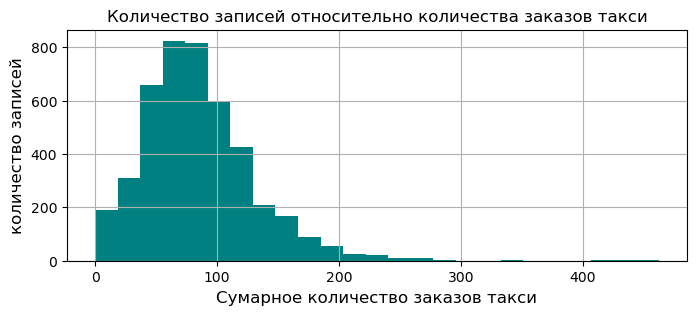

In [18]:
# визуализация количества записей относительно суммарного количества заказов такси
plt.figure(figsize=(8,3))
plt.hist(df['num_orders'], bins=25, color='teal')
plt.grid(True)
plt.title('Количество записей относительно количества заказов такси')
plt.xlabel('Сумарное количество заказов такси', fontsize=12)
plt.ylabel('количество записей', fontsize=12)

plt.show()

- Данные имеют значения, близкие к нормальному распределению. 
- Присутствуют значения, которые значительно отличаются от среднего, но обработка их не представляется возможным, тк утрапится хронологический порядок записей.

### Визуализация временного ряда
- Посмотрим на тренд и сезонность всего временного ряда
- Визуализируем данные за последний месяц

__Визуализация всех данных__

<function matplotlib.pyplot.show(close=None, block=None)>

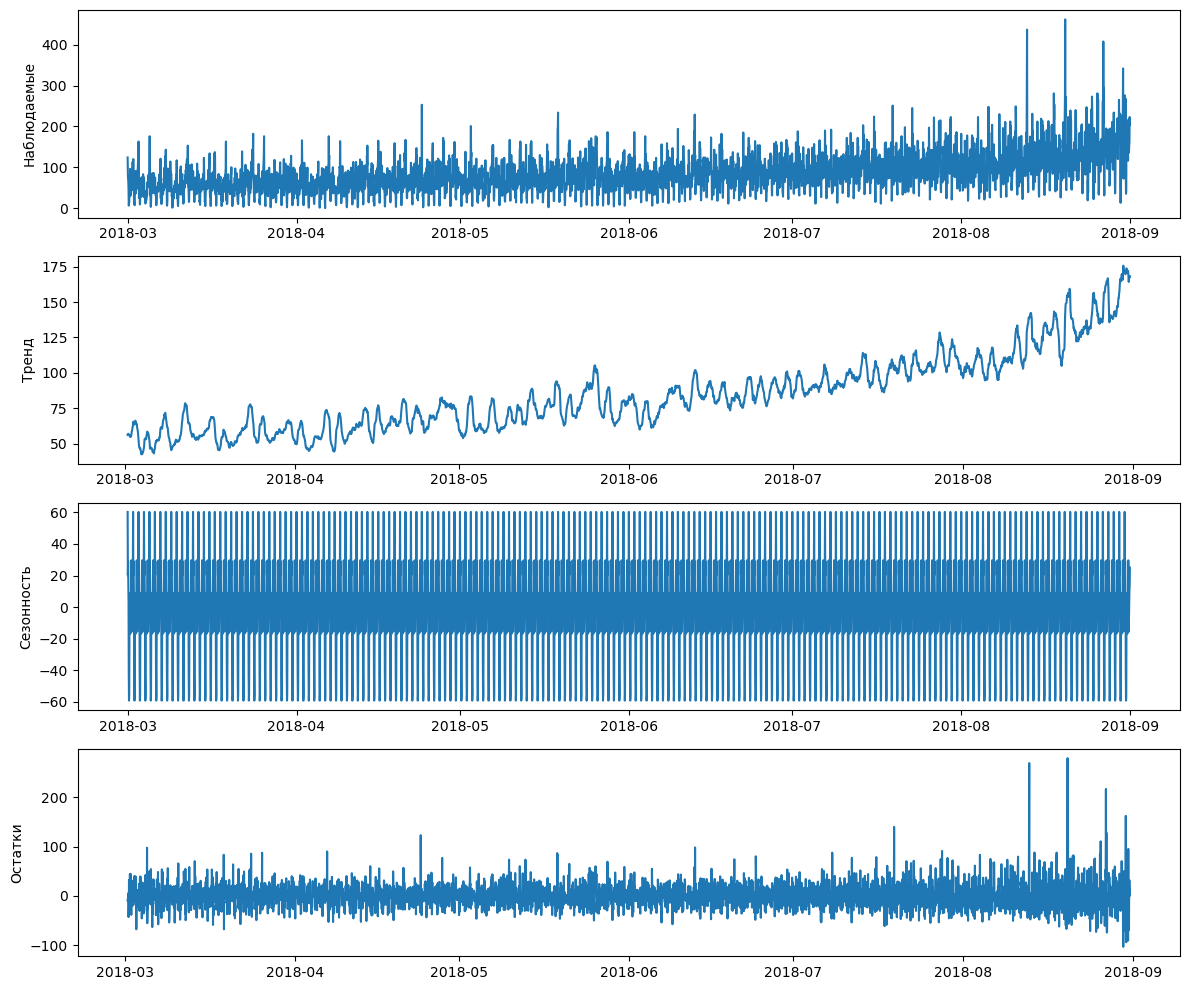

In [19]:
decomposition = seasonal_decompose(df)

plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(df.index, decomposition.observed)
plt.ylabel('Наблюдаемые')

plt.subplot(4, 1, 2)
plt.plot(df.index, decomposition.trend)
plt.ylabel('Тренд')

plt.subplot(4, 1, 3)
plt.plot(df.index, decomposition.seasonal)
plt.ylabel('Сезонность')

plt.subplot(4, 1, 4)
plt.plot(df.index, decomposition.resid)
plt.ylabel('Остатки')

plt.tight_layout()
plt.show

- Мы наблюдаем больше остатков в конце датасета, что свидетельствует о бошем разбросе показателей. Это следует учесть при обучении моделей, и может быть выражено в большеей разности между метриками на обучающих и тестовых данных.

__Визуализация наблюдений за последний месяц__

<function matplotlib.pyplot.show(close=None, block=None)>

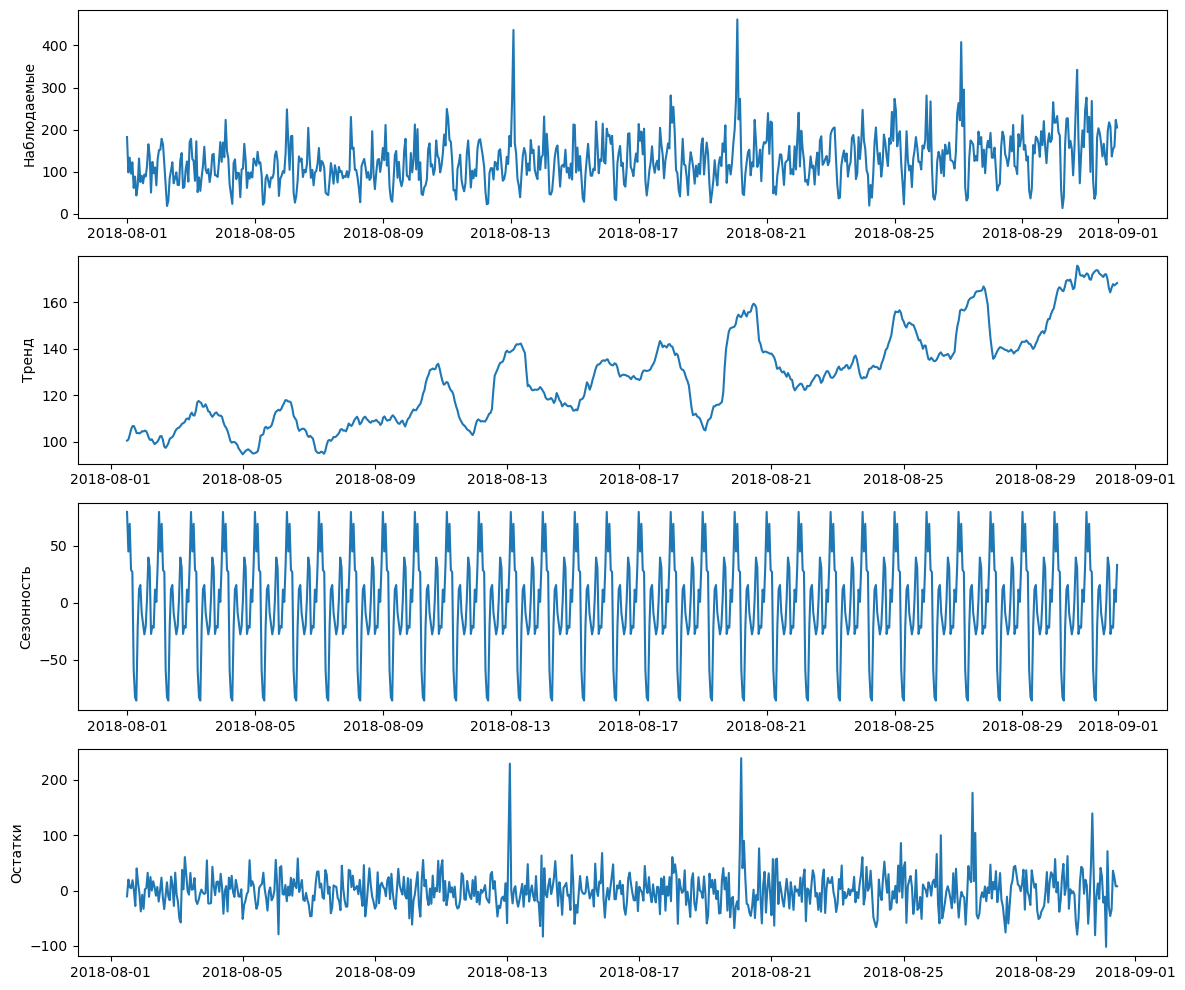

In [20]:
decomposition = seasonal_decompose(df['2018-08':'2018-08'])

plt.figure(figsize=(12, 10))

plt.subplot(4, 1, 1)
plt.plot(df['2018-08':'2018-08'].index, decomposition.observed)
plt.ylabel('Наблюдаемые')

plt.subplot(4, 1, 2)
plt.plot(df['2018-08':'2018-08'].index, decomposition.trend)
plt.ylabel('Тренд')

plt.subplot(4, 1, 3)
plt.plot(df['2018-08':'2018-08'].index, decomposition.seasonal)
plt.ylabel('Сезонность')

plt.subplot(4, 1, 4)
plt.plot(df['2018-08':'2018-08'].index, decomposition.resid)
plt.ylabel('Остатки')

plt.tight_layout()
plt.show

__Визуализация наблюдений за последнюю неделю__

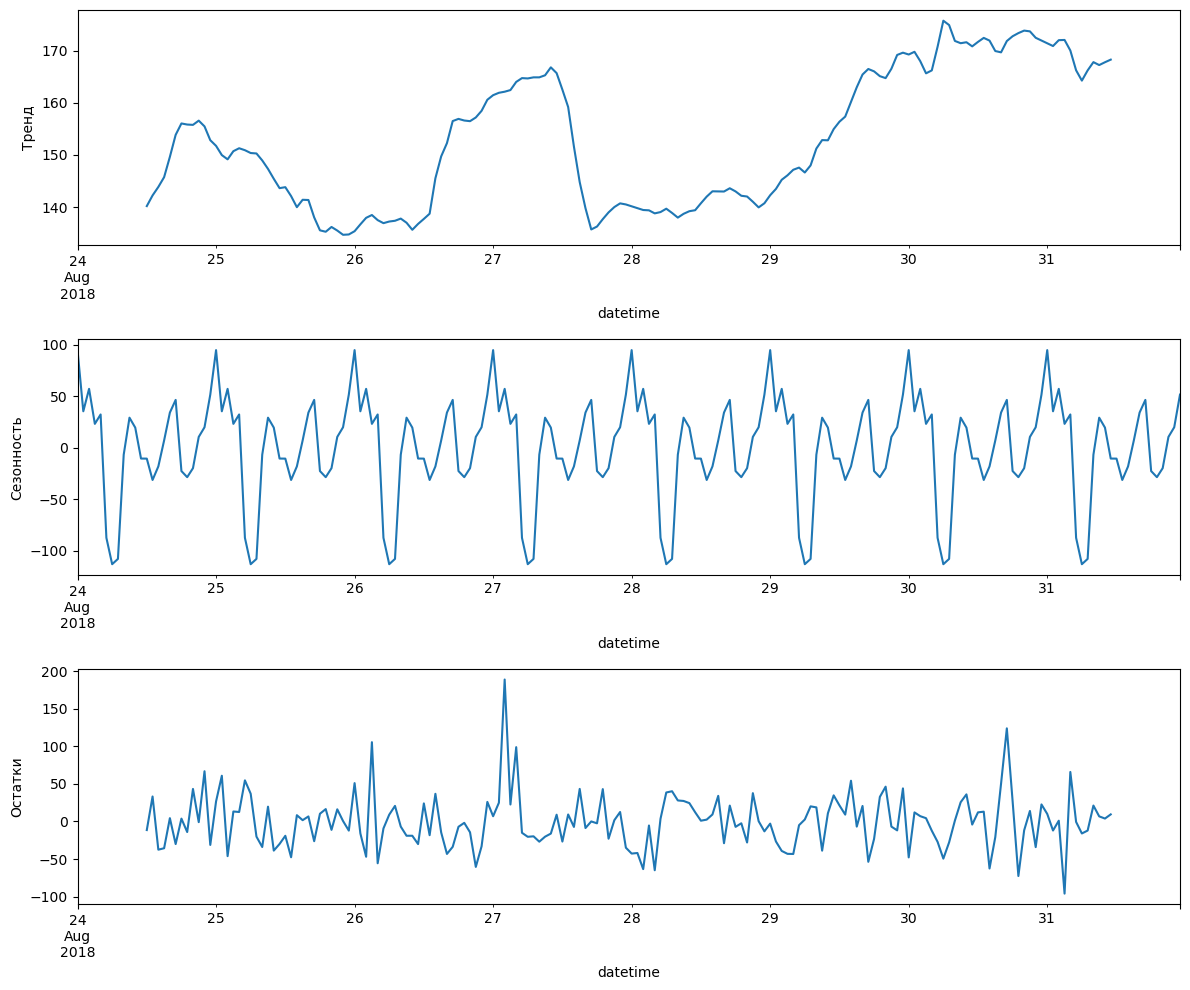

In [21]:
decomposed = seasonal_decompose(df['2018-08-24':'2018-08-31'])
plt.figure(figsize=(12, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.ylabel('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.ylabel('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.ylabel('Остатки')
plt.tight_layout()

<div style="padding: 30px 25px; border: 2px #6495ed solid">

- По общему тренду видно, увеличение количества заказов такси, в аэропортах, к летнему сезену, по сравнению с зимним.
- В месячном промежутке, наблюдается увеличение заказов к концу месяца
- Присутствует недельная сезонность.
- Так же Следует отметить суточную сезонность, но ночные часы приходся пик заказов.
    
</div>

### Стационарность  временного ряда
- Найдём скользящее стандартное отклонение

In [22]:
# копия датасета
df_st = df.copy()

In [23]:
df_st['mean'] = df_st['num_orders'].rolling(15).mean()
df_st['std'] = df_st['num_orders'].rolling(15).std()

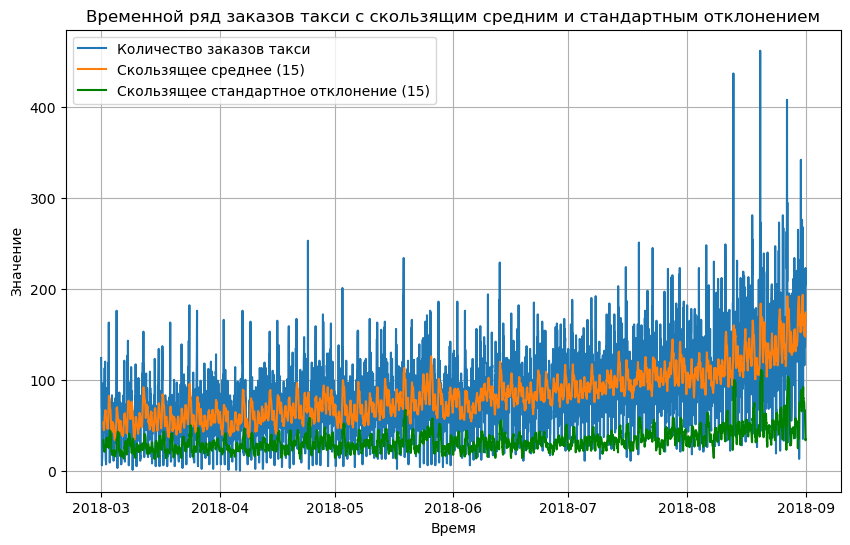

In [24]:
plt.figure(figsize=(10, 6))
# График временного ряда, скользящего среднего и стандартного отклонения
plt.plot(df_st.index, df_st['num_orders'], label='Количество заказов такси')
plt.plot(df_st.index, df_st['mean'], label='Скользящее среднее (15)')
plt.plot(df_st.index, df_st['std'], color='g', label='Скользящее стандартное отклонение (15)')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Временной ряд заказов такси с скользящим средним и стандартным отклонением')
plt.legend()
plt.grid(True)
plt.show()

- Временной ряд не является стационарным, так как у него меняется среднее значение.

### Разности временного ряда

In [25]:
df_st['num_orders'] = df_st['num_orders'] - df_st['num_orders'].shift()
df_st['mean'] = df_st['num_orders'].rolling(15).mean()
df_st['std'] = df_st['num_orders'].rolling(15).std()

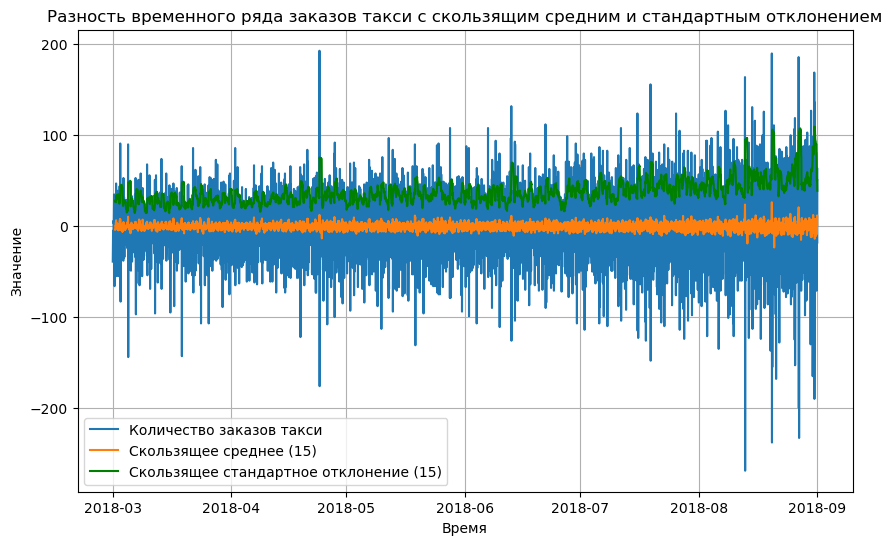

In [26]:
plt.figure(figsize=(10, 6))
# График временного ряда, скользящего среднего и стандартного отклонения
plt.plot(df_st.index, df_st['num_orders'], label='Количество заказов такси')
plt.plot(df_st.index, df_st['mean'], label='Скользящее среднее (15)')
plt.plot(df_st.index, df_st['std'], color='g', label='Скользящее стандартное отклонение (15)')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.title('Разность временного ряда заказов такси с скользящим средним и стандартным отклонением')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# удаление временной таблицы
df_st = None

<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
- Тренд временного ряда при разности значений стал нулевым
- Одноко, данные стали более стационарны, как следствие, их можно прогнозировать
    
</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Подготовка данных к построению модели
    
</div>

## Создание признаков
- Из временных признаков нас интересует только значение часа, тк данные представлемы за пол гота, значение года и месяца использовать нецелесобразно, тк не возможно опредлить сезонность этих признаков.
- Лаги ограничим 168, сюда войдут основные сезонные значения:
    - 24-й лаг, который будет отражать суточную сезонность
    - 168-й лаг, который будет отражать недельную сезонность
- Скользяшее среднее за неделю

In [28]:
def make_features(df , max_lag, rolling_mean_size=7):
    # получение значения часа из индекса
    df['hour'] = df.index.hour
    # лаги
    lag_columns = {}
    for lag in range(1, max_lag + 1):
        lag_columns['lag_{}'.format(lag)] = df['num_orders'].shift(lag)
    df = pd.concat([df, pd.DataFrame(lag_columns)], axis=1)
    # скользящее среднее
    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    # обработка лаг-пропусков
    df = df.dropna()
    return df

In [29]:
df = make_features(df, 168).copy()
display(df.head(2))

,num_orders,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,86.000000
2018-03-08 01:00:00,78,1,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,99.571429


## Выделение обучающей и тестовой выборок
Разделим данные на обучающую и тестовую выборки. На тест выделим 10% от исходных данных, как требует условие.

In [30]:
X = df.drop('num_orders' , axis=1)
y = df['num_orders'] # целевой признак

# формирование выборок
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

# вывод на экран минимальные и максимальные значения индексов выборок, для подтверждения коректности выборок
display(X_train.index.min(), X_train.index.max())
display(X_test.index.min(), X_test.index.max())

# проверка размерности выборок
for x in ['X_train', 'X_test', 'y_train', 'y_test']:
    print(f'Размерность {x}: {globals()[x].shape} - {len(globals()[x])/len(df):.0%}')

Timestamp('2018-03-08 00:00:00', freq='H')

Timestamp('2018-08-14 06:00:00', freq='H')

Timestamp('2018-08-14 07:00:00', freq='H')

Timestamp('2018-08-31 23:00:00', freq='H')

Размерность X_train: (3823, 170) - 90%
Размерность X_test: (425, 170) - 10%
Размерность y_train: (3823,) - 90%
Размерность y_test: (425,) - 10%


- Выделены обучающая и тестовая выборки, проверен порядок разбиения и размерность.
- Дополничельных преодразований данных не требуется, все данные сформированы из одного признака, как следствие, масштабирование необязательно

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Обучение моделей
    
</div>

__Проведем сравнительный анализ трех моделей, обученных на следующих алгоритмах:__
- Ridge
- LightGBM
- Нейросеть на основе фреймворка PyTorch

__Метрика качества:__ RMSE

- Для подбора гиперпараметров используем библиотеку Optuna

In [64]:
# выборки для кроссвалидации временного ряда
tscv = TimeSeriesSplit(n_splits=4)

# функция для расчета RMSE
def rmse_score(values, predict):
    return sqrt(mean_squared_error(values, predict))

# функция для вывода результатов
def output_results(trial):
    print('Результаты подборы параметров:')
    print('  RMSE:', round(trial.value))
    print('  Params: ')
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Ridge
    
</div>

In [80]:
# optuna
def objective_r(trial):
    # параметры подбора
    alpha = trial.suggest_float('alpha', 0.0, 1.0)
    solver = trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'])
    # экземпляр модели
    model = Ridge(alpha=alpha, solver=solver)
    
    rmse_scores = []
    # кроссвалидация
    for train_id, val_id in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_id], X_train.iloc[val_id]
        y_train_fold, y_val_fold = y_train.iloc[train_id], y_train.iloc[val_id]
        
        model.fit(X_train_fold, y_train_fold)
        val_preds = model.predict(X_val_fold)
        rmse_fold = rmse_score(y_val_fold, val_preds)
        rmse_scores.append(rmse_fold)
    
    return np.mean(rmse_scores)

In [81]:
# подбор гиперпараметров
optuna.logging.set_verbosity(optuna.logging.WARNING)

study_r = optuna.create_study(direction='minimize')
study_r.optimize(objective_r, n_trials=50)

In [82]:
# вывод результатов 
trial_r = study_r.best_trial
output_results(trial_r)

Результаты подборы параметров:
  RMSE: 23
  Params: 
    alpha: 0.621792534385919
    solver: sparse_cg


In [83]:
# обучение модели с лучшими гиперпараметрами на всей обучающей выборке
best_model_r = Ridge(alpha=trial_r.params['alpha'], solver=trial_r.params['solver'])
best_model_r.fit(X_train, y_train)

Ridge(alpha=0.621792534385919, solver='sparse_cg')

<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
- Подобраны оптимальные значения, для модели, основанной на линейном алгоритме Ridge
- Значени метрики качества RMSE на данных для обучения: 23
    
</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## LightGBM
    
</div>

In [76]:
def objective_lgb(trial):
    # параметры подбора
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),           
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
        'max_bin': trial.suggest_int('max_bin', 100, 1000)    
    }

    # экземпляр модели
    model = lgb.LGBMRegressor(**params, random_state=RANDOM_SEED)
    
    rmse_scores = []
    # кроссвалидация
    for train_id, val_id in tscv.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_id], X_train.iloc[val_id]
        y_train_fold, y_val_fold = y_train.iloc[train_id], y_train.iloc[val_id]
        
        model.fit(X_train_fold, y_train_fold)
        val_preds = model.predict(X_val_fold)
        rmse_fold = rmse_score(y_val_fold, val_preds)
        rmse_scores.append(rmse_fold)
    
    return np.mean(rmse_scores)

In [77]:
# подбор гиперпараметров
study_lgb = optuna.create_study(direction='minimize')
study_lgb.optimize(objective_lgb, n_trials=200)

In [78]:
# вывод результатов 
trial_lgb = study_lgb.best_trial
output_results(trial_lgb)

Результаты подборы параметров:
  RMSE: 23
  Params: 
    learning_rate: 0.04260823886506891
    max_depth: 3
    n_estimators: 176
    colsample_bytree: 0.9140755375881686
    reg_alpha: 4.6329367971093815e-09
    reg_lambda: 1.2072129723186368e-06
    max_bin: 208


In [84]:
# обучение модели с лучшими гиперпараметрами на всей обучающей выборке
best_params_lgb = study_lgb.best_params
best_model_lgb = lgb.LGBMRegressor(**best_params_lgb, random_state=RANDOM_SEED)
best_model_lgb.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.9140755375881686,
              learning_rate=0.04260823886506891, max_bin=208, max_depth=3,
              n_estimators=176, random_state=42,
              reg_alpha=4.6329367971093815e-09,
              reg_lambda=1.2072129723186368e-06)

<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
- Подобраны оптимальные значения, для модели, основанной на линейном алгоритме LightGBM
- Значени метрики качества RMSE на данных для обучения: 23
    
</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Нейросеть PyTorch
    
</div>

## Тестирование

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Данные проанализированы
- [ ]  Модель обучена, гиперпараметры подобраны
- [ ]  Качество моделей проверено, выводы сделаны
- [ ]  Значение *RMSE* на тестовой выборке не больше 48